# South African Language Identification Hack 2023

© Explore Data Science Academy

---
### Honour Code

I {**Edidiong Udofia**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.


South Africa, marked by its abundant linguistic variations, embodies a multicultural environment. Language plays a crucial role in enhancing democracy and plays a significant role in shaping the social, cultural, intellectual, economic, and political aspects of South African society. The nation boasts 11 official languages, each enjoying equal recognition. The majority of South Africans are fluent in multiple languages, typically being proficient in at least two or more of the official languages. Given this multilingual populace, it is only natural that our systems and devices also support communication in multiple languages.

In this challenge, I will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

<a id="cont"></a>

## Table of contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Cleaning</a>

<a href=#five>5. Engineering Features</a>

<a href=#six>6. Modeling</a>

<a href=#seven>7. Model Performance</a>

<a href=#seven>8. Submission on Kaggle</a>

<a href=#nine>9. References</a>

<a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>


In [35]:
# data loading dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import pickle


# libraries for NLP
import nltk
from nltk.corpus import stopwords
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# importing libraries for utility from sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier


# importing libraries for modelling form sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# libraries to check model metrics from sklearn
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Enable interactive visualisations in Jupyter
from ipywidgets import interact, interact_manual, widgets
import plotly.express as px

#word cloud visualization
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### Description of dataset
The dataset used for this challenge is the NCHLT Text Corpora collected by the South African Department of Arts and Culture & Centre for Text Technology (CTexT, North-West University, South Africa). The training set was improved through additional cleaning done by Praekelt.

The data is in the form Language ID, Text. The text is in various states of cleanliness. Some NLP techniques will be necessary to clean up the data.

### Language IDs

* afr - Afrikaans
* eng - English
* nbl - isiNdebele
* nso - Sepedi
* sot - Sesotho
* ssw - siSwati
* tsn - Setswana
* tso - Xitsonga
* ven - Tshivenda
* xho - isiXhosa
* zul - isiZulu

In [36]:
# Loading the datasets
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

# Inspecting the first five rows of train and test sets
display(train.head(5))
display(test.head(5))

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


# 2. Data Preprocessing<a id="preprocessing"></a>
[Table of Contents](#contents)

Let's commence do some basic data cleaning and processing

In [37]:
# Checking for null entries
train.isnull().sum()

lang_id    0
text       0
dtype: int64

In [38]:
# Checking for null entries
test.isnull().sum()

index    0
text     0
dtype: int64

There are no null values in the train and test datasets.

In [39]:
# Checking for count of each language
train["lang_id"].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

The train dataset contains 11 languages with 3000 sentences from each language. The dataset is therefore very balanced and has no missing values. The dataset is ready to be used to train a machine learning model.

In [40]:
#Data Information
def data_info(data):
    
    print('1) Number of columns are: ',data.shape[1])
    print('2) Number of rows are: ',data.shape[0])
    print('3) Total number of data-points:',data.size)
    numerical_features = [f for f in data.columns if data[f].dtypes!='O']
    print('4) Count of Numerical Features:',len(numerical_features))
    cat_features = [c for c in data.columns if data[c].dtypes=='O']
    print('5) Count of Categorical Features:',len(cat_features))

In [41]:
print('The train data has the following information:')
data_info(train)

The train data has the following information:
1) Number of columns are:  2
2) Number of rows are:  33000
3) Total number of data-points: 66000
4) Count of Numerical Features: 0
5) Count of Categorical Features: 2


The function has given us information on the number of rows, columns, data points and also tell us which features are numerical or categorical.

The information above reveals the data is 100% textual in nature because the total number of numerical features is 2.

In [42]:
# Checking for missing values
def check_features_with_missing_values(data):
    
    x = data.isnull().sum().sum()/(data.shape[0]*data.shape[1])*100
    print('Percentage of Overall Missing Values is ' ,round(x,2) ,'%')
    print('Missing Value Estimation :')
    for i in data.columns:
        col_miss = round(data[i].isnull().sum()/len(data[i]) * 100, 2)
        if data[i].isna().sum() > 0:
            print('The Feature',i,'has a total of '+ str(data[i].isna().sum()) + ' missing values which translates to ' +
                 str(col_miss) + '% of values missing in that column')

In [43]:
print('Missing value breakdown: ')
check_features_with_missing_values(train)

Missing value breakdown: 
Percentage of Overall Missing Values is  0.0 %
Missing Value Estimation :


Our dataset contains no missing value. Let's explore other data cleaning techniques in the next section.

In [44]:
#Checking for class balance
def class_distribution(data, class_variable):
    data[class_variable].value_counts().plot(kind = 'bar', figsize =(12,5))
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()

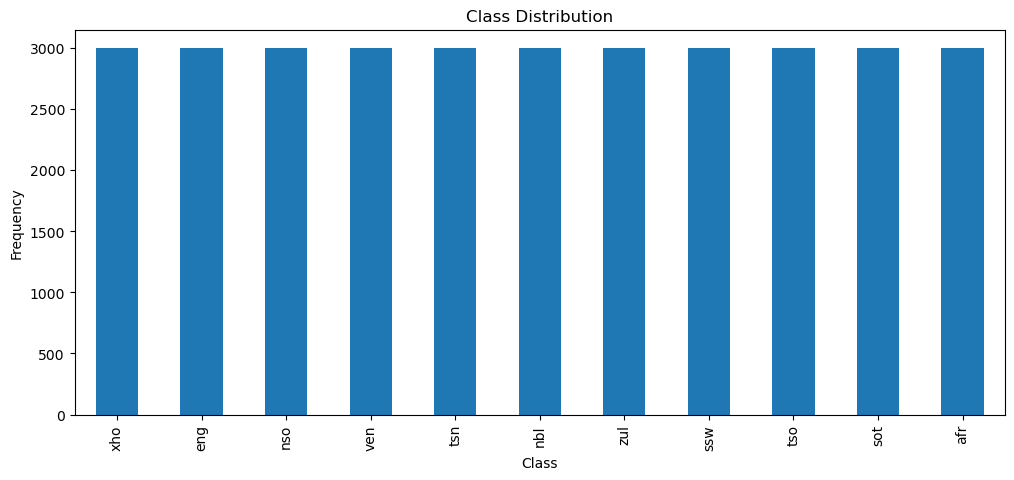

In [45]:
class_distribution(train, 'lang_id')

The chart indicates that the bars corresponding to each class in the entire dataset are consistently aligned at the same level. This suggests that the classes are evenly balanced.

In [46]:
# Checking for duplicates
def check_duplicates(data, column_name):
    
    duplicates = pd.DataFrame(data[column_name].duplicated())
    num_of_duplicates = len(duplicates[duplicates[column_name] == True])
    if num_of_duplicates > 0:
        print("Duplicates detected. We have {} number of duplicate value in the dataset".format(num_of_duplicates))
    else:
        print("No duplicates. All good")

In [47]:
check_duplicates(train,'text')

Duplicates detected. We have 3052 number of duplicate value in the dataset


It is crucial to address duplicate values present in our dataset, and this issue will be addressed during the data cleaning process. While handling these duplicates, it's important to closely monitor their impact on the balance of classes.

# 3. Exploratory Data Analysis<a id="EDA"></a>
[Table of Contents](#contents)

## 3.1 Word Cloud

To check the popularity of words used in  each language, word cloud will be employed. This is helpful to understand the tone/usage of words for each language in the corpus.

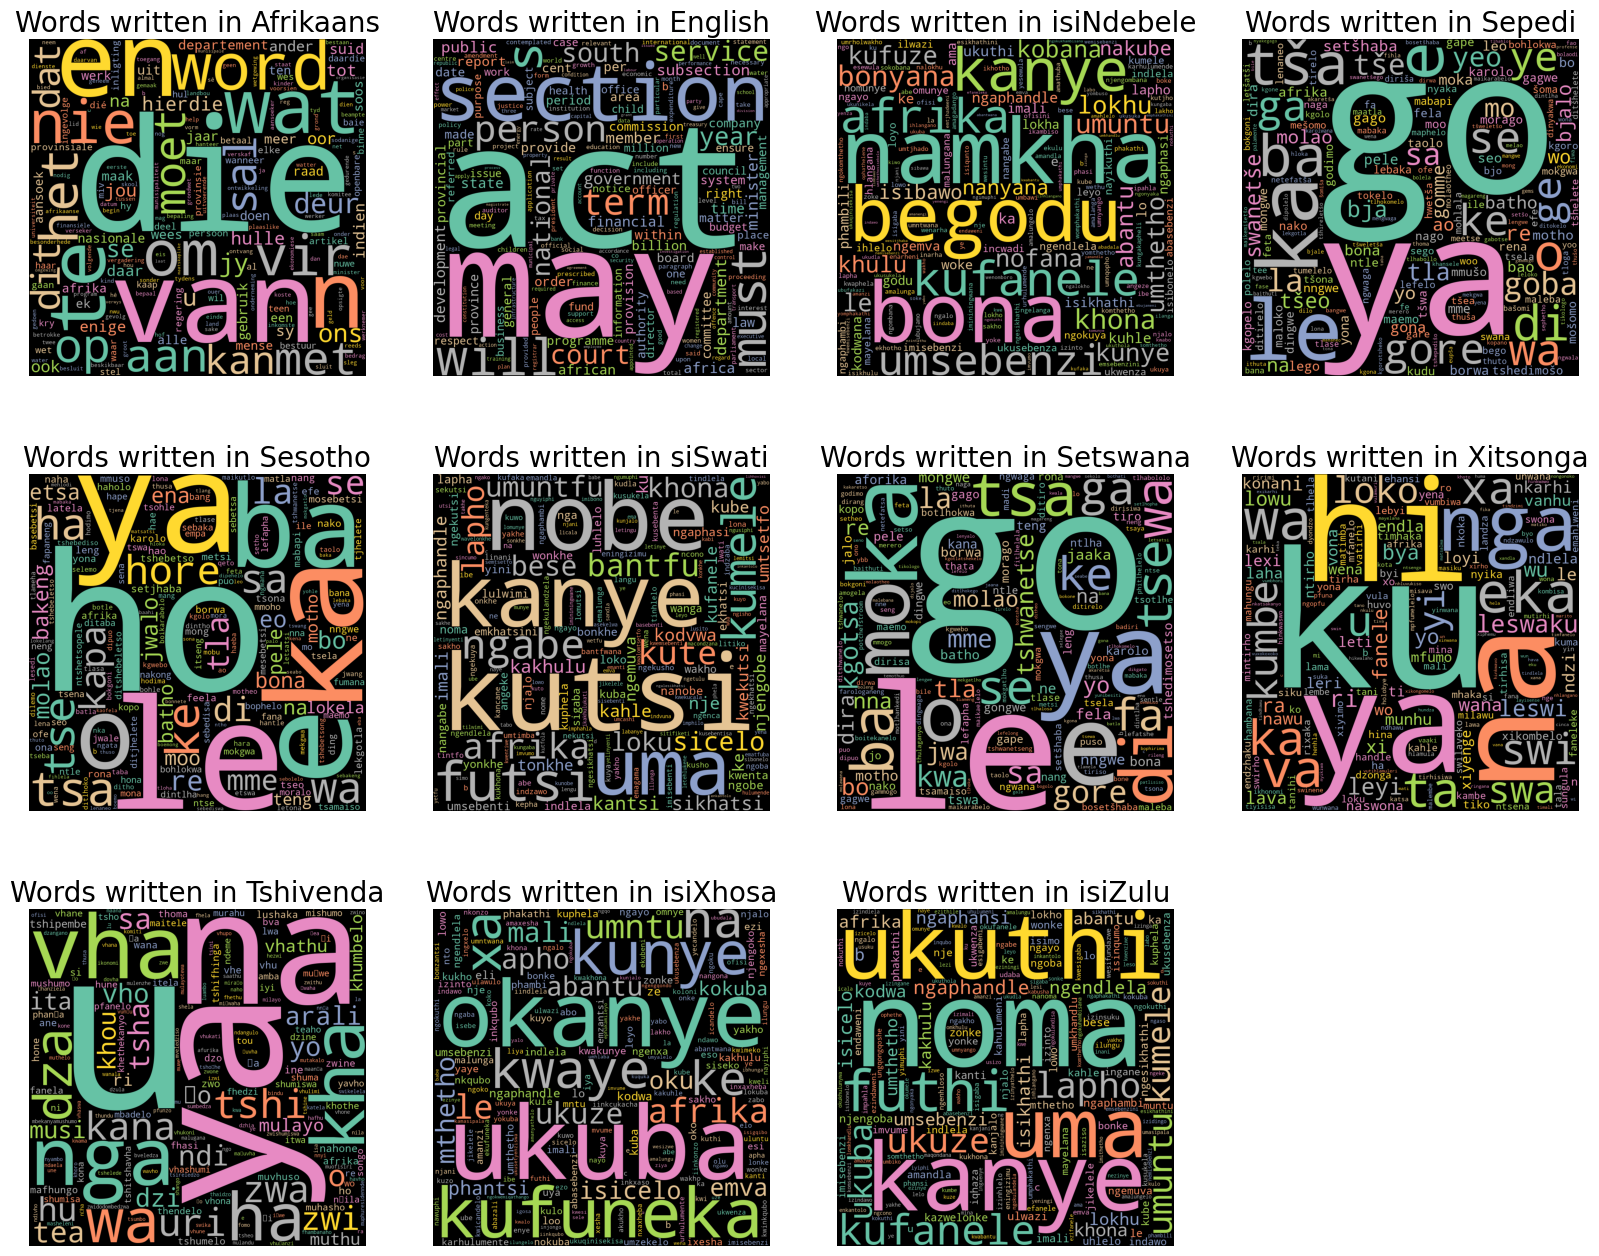

In [49]:
# Generate wordcloud
# Initialize news, pro, neutral and anti messages
lang_id = ['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso', 'sot', 'afr']

afr = train[train['lang_id'] == 'afr']['text']
eng = train[train['lang_id'] == 'eng']['text']
nbl = train[train['lang_id'] == 'nbl']['text']
nso = train[train['lang_id'] == 'nso']['text']
sot = train[train['lang_id'] == 'sot']['text']
ssw = train[train['lang_id'] == 'ssw']['text']
tsn = train[train['lang_id'] == 'tsn']['text']
tso = train[train['lang_id'] == 'tso']['text']
ven = train[train['lang_id'] == 'ven']['text']
xho = train[train['lang_id'] == 'xho']['text']
zul = train[train['lang_id'] == 'zul']['text']


afr = [word for line in afr for word in line.split()]
eng = [word for line in eng for word in line.split()]
nbl = [word for line in nbl for word in line.split()]
nso = [word for line in nso for word in line.split()]
sot = [word for line in sot for word in line.split()]
ssw = [word for line in ssw for word in line.split()]
tsn = [word for line in tsn for word in line.split()]
tso = [word for line in tso for word in line.split()]
ven = [word for line in ven for word in line.split()]
xho = [word for line in xho for word in line.split()]
zul = [word for line in zul for word in line.split()]

    
# Define a function to plot word cloud
def plot_cloud(afr, eng, nbl, nso, sot, ssw, tsn, tso, ven, xho, zul):
    # Import image to np.array
    #mask = np.array(Image.open('comment.png'))
    mask1 = np.array(Image.open(r"C:\Users\ctair\OneDrive\Documents\Explore AI Academy\Advanced Classification\Hackathon\Pentagon.png"))
    
    afr = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(afr))
    
    eng = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(eng))
    
    nbl = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(nbl))
    
    nso = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(nso))
    
    sot = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(sot))
    
    ssw = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(ssw))
    
    tsn = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(tsn))
    
    tso = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(tso))
    
    ven = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(ven))
    
    xho = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(xho))
    
    zul = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(zul))

    
    # Set figure size
    plt.figure(figsize = (20,16))
    plt.subplot(3,4,1)
    plt.title('Words written in Afrikaans', fontsize = 20)
    # Display image
    plt.imshow(afr) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,2)
    plt.title('Words written in English', fontsize = 20)
    # Display image
    plt.imshow(eng) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,3)
    plt.title('Words written in isiNdebele', fontsize = 20)
    # Display image
    plt.imshow(nbl) 
    # No axis details
    plt.axis("off")

    plt.subplot(3,4,4)
    plt.title('Words written in Sepedi', fontsize = 20)
    # Display image
    plt.imshow(nso) 
    # No axis details
    plt.axis("off")
  
    plt.subplot(3,4,5)
    plt.title('Words written in Sesotho', fontsize = 20)
    # Display image
    plt.imshow(sot) 
    # No axis details
    plt.axis("off")
        
    plt.subplot(3,4,6)
    plt.title('Words written in siSwati', fontsize = 20)
    # Display image
    plt.imshow(ssw) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,7)
    plt.title('Words written in Setswana', fontsize = 20)
    # Display image
    plt.imshow(tsn) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,8)
    plt.title('Words written in Xitsonga', fontsize = 20)
    # Display image
    plt.imshow(tso) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,9)
    plt.title('Words written in Tshivenda', fontsize = 20)
    # Display image
    plt.imshow(ven) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,10)
    plt.title('Words written in isiXhosa', fontsize = 20)
    # Display image
    plt.imshow(xho) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,11)
    plt.title('Words written in isiZulu', fontsize = 20)
    # Display image
    plt.imshow(zul) 
    # No axis details
    plt.axis("off")
    

plot_cloud(afr, eng, nbl, nso, sot, ssw, tsn, tso, ven, xho, zul)

Based on the presented word clouds, the larger words within each category seem to reflect higher frequencies, while smaller words indicate lower occurrence. For instance, in the English word cloud, words like 'act,' 'section,' and 'may' exhibit more frequent occurrences in the corpus data. The prevalence of these terms suggests that the texts in this category predominantly focus on subjects related to politics, government, or law.







<a id="four"></a>
## 4. Data cleaning
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### Dealing with duplicates

In the previous section where the detection of duplicates was carried out, it was found out that there are presence of duplicates in the train set, we will have to handle them and monitor the effect of this action on the data class

In [50]:
def remove_duplicates(data):
    
    print("Shape before dropping duplicates: {} ".format(data.shape))
    data = data.drop_duplicates()
    print('Shape after dropping duplicates: {}'.format(data.shape))
    return data

In [51]:
train = remove_duplicates(train)

Shape before dropping duplicates: (33000, 2) 
Shape after dropping duplicates: (29948, 2)


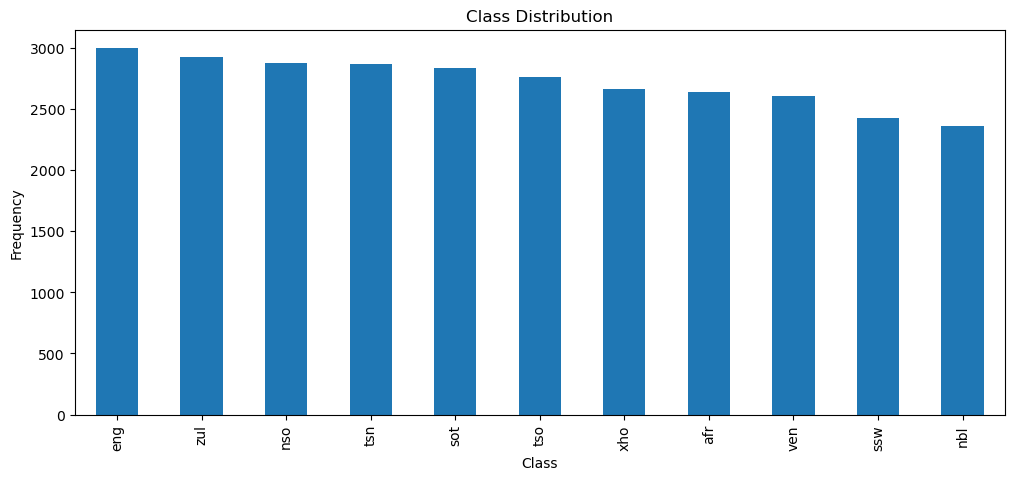

In [52]:
#Checking the effect of dropping duplicates on dataset class
class_distribution(train,'lang_id')

Looking at the visualization, the removal of duplicate entries did not significantly alter the distribution of classes. It is evident that each class maintains nearly equal representation. Training a model with this dataset is unlikely to result in algorithmic bias favoring the majority class.

The class distribution shows that `English` has the highest representation in the dataset while ` isiNdebele` has the least representation.

### 4.1 Remove punctuations and digits characters <a id="four"></a>
<a class="anchor" id="1.1"></a>

In [53]:
# Import string library to form basis for punctuations
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [54]:
def remove_punctuation(text):
    """Takes in a text and removes punctuations"""
    return ''.join([l for l in text if l not in string.punctuation])

In [56]:
def remove_digit(text):
    """Takes in a text and removes number characters"""
    return ''.join([i for i in text if not i.isdigit()])

In [57]:
# Applying remove_punctuation and remove_digit function on dataset
train['text'] = train['text'].apply(remove_punctuation,remove_digit)

### 4.2  Tokenization and Lemmatization

For further data cleaning and wrangling, the tokenization and lemmatization methods were employed.

Tokenization is the process of breaking down a phrase, sentence, paragraph, or even an entire text document into simpler components, like individual words or phrases. Tokens are the name for each of these smaller components. Tokens are considered as a first step for stemming and lemmatization.

Lemmatization, also known as lemmatization, is a widely used technique in natural language processing that involves grouping together a word's inflected forms so they may be analyzed as a single entity and distinguished by the word's lemma, or dictionary form. Lemmatization aims to condense a word's inflectional and occasionally derived forms to a basic form that is shared by all of them.

In [58]:
def token_lem (text):
   
    tokens = word_tokenize(text)

    # Define lemmatiser
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in tokens]
   

    return ' '.join([x for x in lem])

In [59]:
# Applying tokenization and lemmatization function on dataset
train['text'] = train['text'].apply(token_lem)

<a id="five"></a>
## 5. Features Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

When managing the process of inputting and outputting data for a machine learning model, a useful tool is the machine learning pipeline. This is recognized as a comprehensive framework that oversees the flow of data into and out of a machine learning model, either as a single model or a series of interconnected models. The pipeline encompasses various stages, such as raw data input, feature extraction, model output, machine learning model integration, inclusion of model parameters, and the final prediction outputs.

In this context, a machine learning pipeline is applied to facilitate the extraction of features from our text data. The pipeline systematically carries out the following steps in a sequential manner to extract these features and generate predictions. These steps include:

* Count Vectorization: The CountVectorizer tool in Scikit-learn is used to turn a group of text documents into a vector of term/token counts. Additionally, it enables text data to be pre-processed before being turned into a vector form. Its capabilities turn it into a very versatile feature representation module for text(4).


* TF-ID Transformer: With TF-ID transformer, a count matrix is transformed into a normalised tf or tf-idf representation. To reduce the impact of tokens that appear often in a corpus, tf-idf is used in place of the raw frequencies of occurrence of a token in a specific document (5)


* Model: This represents the adopted Machine Learning model.

In [61]:
# Define the logistic regression model
logit = LogisticRegression()

# Initialize the pipeline
pipe = Pipeline([
    ('vect', CountVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer()),
    ('model', logit)
])

<a id="six"></a>
## 6. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Having sorted feature extraction, the next thing to do is modelling. We will consider different Machine Learning algorithms for classification tasks. They include:

* Logistics Regression
* Naive Bayes (Multinomial Model)
* Random Forest Classifier

### 6.1 Data Preparation for modelling

To maintain consistency between the test set and the training set, it is crucial for the test set to undergo the same data transformation process applied to the training set. In this context, this objective is successfully fulfilled.

In [63]:
# Removing punctuations and digits from test set
test['text'] = test['text'].apply(remove_punctuation, remove_digit)

In [64]:
# Apply tokenization and lemmatization on test set
test['text'] = test['text'].apply(token_lem)

### 6.2 Splitting datasets into train and validation sets

In [65]:
# Defining features and target
X = train['text']
y = train['lang_id']

In [66]:
# Splitting into train and validating with sklearn.train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=45)

In [67]:
y_train.shape

(23958,)

In [68]:
def train_model(model, X_train, y_train, X_test, y_test):
    
    # Building pipeline
    pipe = Pipeline([(
    'vect', CountVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer()),
    ('model', model)])
    
    # Training model
    pipe.fit(X_train,y_train)
    
    # Getting predictions
    prediction = pipe.predict(X_test)
    
    # Classification report
    print(classification_report(y_test,prediction))

### 6.3 Logistic Regression

Logistics regression is a predictive analytics model that is used to describe data and explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.Sometimes, it can also be applied to a dependent variable that is multi-classed (ie have more than 2 variables). The model was adopted because it is a classification algorithm and suited our use case as well.

In [69]:
# Initializing the model
logit = LogisticRegression(random_state=42,multi_class='ovr',n_jobs=1, C=1e5,max_iter=4000)

In [70]:
# The training process
train_model(logit, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       587
         eng       1.00      1.00      1.00       596
         nbl       0.99      0.97      0.98       463
         nso       1.00      1.00      1.00       547
         sot       1.00      1.00      1.00       567
         ssw       1.00      0.99      0.99       508
         tsn       1.00      1.00      1.00       578
         tso       1.00      1.00      1.00       542
         ven       1.00      1.00      1.00       528
         xho       0.99      1.00      0.99       507
         zul       0.97      0.99      0.98       567

    accuracy                           0.99      5990
   macro avg       1.00      0.99      0.99      5990
weighted avg       1.00      0.99      0.99      5990



### 6.4 Linear Support vector Classifier (SVM)

A linear model for classification and regression issues is the SVM, or Support Vector Machine. It works well for many real-world issues and can solve both linear and non-linear problems. The SVM concept is straightforward: A line or a hyperplane that divides the data into classes is produced by the algorithm7.

In this section, I shall implement the linearSVC.

In [71]:
svc = SVC()

In [72]:
train_model(svc, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       587
         eng       1.00      1.00      1.00       596
         nbl       0.99      0.96      0.98       463
         nso       1.00      1.00      1.00       547
         sot       1.00      1.00      1.00       567
         ssw       1.00      0.98      0.99       508
         tsn       1.00      1.00      1.00       578
         tso       1.00      1.00      1.00       542
         ven       1.00      1.00      1.00       528
         xho       0.99      1.00      0.99       507
         zul       0.96      0.99      0.97       567

    accuracy                           0.99      5990
   macro avg       0.99      0.99      0.99      5990
weighted avg       0.99      0.99      0.99      5990



### 6.5 Naive Bayes (MultinomialNB)

Mostly employed in Natural Language Processing, the Multinomial Naive Bayes algorithm is a probabilistic learning technique (NLP). The method, which guesses the tag of a text such as an email or newspaper article, is based on the Bayes theorem. For a given sample, it determines the probabilities of each tag, and then outputs the tag with the highest probability.

The Naive Bayes classifier is a collection of many methods, all of which are based on the idea that each feature being classified is independent of every other feature. The existence or absence of one feature has no bearing on the other feature's existence or absence.

In [73]:
naive = MultinomialNB()

In [76]:
train_model(naive, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       587
         eng       0.99      1.00      1.00       596
         nbl       1.00      0.97      0.99       463
         nso       1.00      1.00      1.00       547
         sot       1.00      1.00      1.00       567
         ssw       1.00      0.99      1.00       508
         tsn       1.00      1.00      1.00       578
         tso       1.00      1.00      1.00       542
         ven       1.00      1.00      1.00       528
         xho       1.00      1.00      1.00       507
         zul       0.98      1.00      0.99       567

    accuracy                           1.00      5990
   macro avg       1.00      1.00      1.00      5990
weighted avg       1.00      1.00      1.00      5990



<a id="seven"></a>
## 7. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Let's discuss the accuracy of the models. 

Based on the mentioned categorization study, the Linear SVC and Naive Bayes models achieved the highest accuracy of 1.0. This suggests that these models performed exceptionally well on the training data. However, there is an indication of some overfitting, especially in the case of the Linear SVC model, as its performance declined noticeably when presented with unseen data.

Although the Logistic Regression classifier had a training accuracy score of 0.99, it outperformed the Linear SVC model on new, unseen data, as evident from the test accuracy values of both models.

In the overall assessment, the Multinomial Naive Bayes model surpassed its counterparts and will be taken into consideration during the full training and development of the language classification model.

<a id="seven"></a>
## 8. Submission on Kaggle
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [77]:
# Preparing train and test data for Kaggle submission
X_train_full = train['text']
y_train_full = train['lang_id']
X_test_full = test['text']

In [78]:
kaggle_pipe = Pipeline([('vect',CountVectorizer(stop_words='english',
                                         min_df=2,
                                         max_df=0.9,
                                         ngram_range=(3,6),analyzer=('char'))),
                 ('tfidf',TfidfTransformer()),
                 ('model',logit)])

In [79]:
kaggle_pipe.fit(X_train_full, y_train_full)

Pipeline(steps=[('vect',
                 CountVectorizer(analyzer='char', max_df=0.9, min_df=2,
                                 ngram_range=(3, 6), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('model',
                 LogisticRegression(C=100000.0, max_iter=4000,
                                    multi_class='ovr', n_jobs=1,
                                    random_state=42))])

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

# Assuming you have your training data X_train_full and corresponding labels y_train_full

# Define the logistic regression model
logit = LogisticRegression()

# Initialize the pipeline for submission
pipe_submit = Pipeline([
    ('vect', CountVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer()),
    ('model', logit)
])

# Fit the pipeline with your full training data
pipe_submit.fit(X_train_full, y_train_full)

# Now you can use the fitted pipeline to make predictions
y_pred_kaggle = pipe_submit.predict(X_test_full)

In [91]:
# Submission to Kaggle
submit = test.index + 1
Final_Table = {'index': submit, 'lang_id': y_pred_kaggle}
submission = pd.DataFrame(data=Final_Table)
submission = submission[['index', 'lang_id']]

# Saving submission as CSV file
submission.to_csv('submission_logit.csv', index=False)

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

# Assuming you have your training data X_train_full and corresponding labels y_train_full

# Define the logistic regression model
naive = naive = MultinomialNB()

# Initialize the pipeline for submission
pipe_submit = Pipeline([
    ('vect', CountVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer()),
    ('model', naive)
])

# Fit the pipeline with your full training data
pipe_submit.fit(X_train_full, y_train_full)

# Now you can use the fitted pipeline to make predictions
y_pred_kaggle = pipe_submit.predict(X_test_full)

In [94]:
# Submission to Kaggle
submit = test.index + 1
Final_Table = {'index': submit, 'lang_id': y_pred_kaggle}
submission = pd.DataFrame(data=Final_Table)
submission = submission[['index', 'lang_id']]

# Saving submission as CSV file
submission.to_csv('submission_naive.csv', index=False)

<a id="nine"></a>
## 9. References
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

* 1. https://www.analyticsvidhya.com/blog/2019/07/how-get-started-nlp-6-unique-ways-perform-tokenization/
* 2. https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
* 3. https://c3.ai/glossary/machine-learning/machine-learning-pipeline/#:~:text=A%20machine%20learning%20pipeline%20is,model%20parameters%2C%20and%20prediction%20outputs.
* 4. https://www.educative.io/answers/countvectorizer-in-python
* 5. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
* 6. https://www.upgrad.com/blog/multinomial-naive-bayes-explained/#:~:text=What%20is%20the%20Multinomial%20Naive,of%20email%20or%20newspaper%20article.
* 7. https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989